# Importing Repositories

In [47]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
from scipy import stats
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize']=(20,10)

In [48]:
def missing_zero_values_table(df):
        ''''Takes a pandas dataframe and returns a statistics table that explains the missing and 
        zero values'''
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Our selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Importing data files

## Paths for files

In [49]:
path_price = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadPrices_12.1.D'
path_totalload = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadTotalLoadForecast'
path_windsolar = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadGenerationForecastForWindAndSolar_14.1.D'

## Price Timeseries Importing

In [50]:
f_price = glob.glob(path_price + "/*.csv")
dprice = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_price]

price_ts = pd.concat(dprice)
price_ts = price_ts[price_ts['AreaCode'] == '10YGB----------A']
price_ts = price_ts[['DateTime', 'Price']]
price_ts.sort_values(by='DateTime', ascending=True)
price_ts.reset_index(drop=True)
price_ts.set_index('DateTime', inplace=True)
price_ts = price_ts.resample('H').fillna('nearest')
price_ts


,Price
DateTime,
2014-12-18 23:00:00,39.91
2014-12-19 00:00:00,36.59
2014-12-19 01:00:00,31.91
2014-12-19 02:00:00,22.53
2014-12-19 03:00:00,20.96
...,...
2020-12-31 18:00:00,71.30
2020-12-31 19:00:00,61.04
2020-12-31 20:00:00,60.39


## Wind and Solar Timeseries Importing

### Wind Off Shore

In [51]:
f_windoff = glob.glob(path_windsolar + "/*.csv")
dwindoff = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windoff]

windoff_ts = pd.concat(dwindoff)
windoff_ts = windoff_ts[windoff_ts['AreaCode'] == '10YGB----------A']
windoff_ts = windoff_ts[windoff_ts['ProductionType'] == 'Wind Offshore']
windoff_ts = windoff_ts[['DateTime', 'AggregatedGenerationForecast']]
windoff_ts.rename(columns={"AggregatedGenerationForecast":"Wind OffGeneration"}, inplace=True)
windoff_ts.sort_values(by='DateTime', ascending=True)
windoff_ts.reset_index(drop=True)
windoff_ts.drop_duplicates(subset=['DateTime'], inplace=True)
windoff_ts.set_index('DateTime', inplace=True)
test = pd.merge(price_ts, windoff_ts, right_index=True, left_index=True)
test = test.asfreq('H')
test.index


DatetimeIndex(['2014-12-30 00:00:00', '2014-12-30 01:00:00',
               '2014-12-30 02:00:00', '2014-12-30 03:00:00',
               '2014-12-30 04:00:00', '2014-12-30 05:00:00',
               '2014-12-30 06:00:00', '2014-12-30 07:00:00',
               '2014-12-30 08:00:00', '2014-12-30 09:00:00',
               ...
               '2020-12-31 13:00:00', '2020-12-31 14:00:00',
               '2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=52655, freq='H')

### Wind On Shore Data

In [52]:
f_windon = glob.glob(path_windsolar + "/*.csv")
dwindon = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windon]

windon_ts = pd.concat(dwindon)
windon_ts = windon_ts[windon_ts['AreaCode'] == '10YGB----------A']
windon_ts = windon_ts[windon_ts['ProductionType'] == 'Wind Onshore']
windon_ts = windon_ts[['DateTime', 'AggregatedGenerationForecast']]
windon_ts.rename(columns={"AggregatedGenerationForecast":"Wind OnGeneration"}, inplace=True)
windon_ts.sort_values(by='DateTime', ascending=True)
windon_ts.reset_index(drop=True)
windon_ts.drop_duplicates(subset=['DateTime'], inplace=True)
windon_ts.set_index('DateTime', inplace=True)
test = pd.merge(test, windon_ts, right_index=True, left_index=True)

### Solar Data

In [53]:
f_solar = glob.glob(path_windsolar + "/*.csv")
dsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_solar]

solar_ts = pd.concat(dsolar)
solar_ts = solar_ts[solar_ts['AreaCode'] == '10YGB----------A']
solar_ts = solar_ts[solar_ts['ProductionType'] == 'Solar']
solar_ts = solar_ts[['DateTime', 'AggregatedGenerationForecast']]
solar_ts.rename(columns={"AggregatedGenerationForecast":"Solar Generation"}, inplace=True)
solar_ts.sort_values(by='DateTime', ascending=True)
solar_ts.reset_index(drop=True)
solar_ts.drop_duplicates(subset=['DateTime'], inplace=True)
solar_ts.set_index('DateTime', inplace=True)
test = pd.merge(test, solar_ts, right_index=True, left_index=True)

In [54]:
test

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation
DateTime,,,,
2014-12-30 00:00:00,42.97,996.58,2363.80,0.0
2014-12-30 01:00:00,40.13,1059.20,2413.88,0.0
2014-12-30 02:00:00,36.90,1123.27,2450.75,0.0
2014-12-30 03:00:00,34.98,1177.54,2500.78,0.0
2014-12-30 04:00:00,33.63,1188.21,2536.07,0.0
...,...,...,...,...
2020-12-31 18:00:00,71.30,2644.97,3028.41,0.0
2020-12-31 19:00:00,61.04,2707.55,3046.72,0.0
2020-12-31 20:00:00,60.39,2695.01,3053.60,0.0


### Demand Data

In [55]:
ddemand = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\demandto2020.csv',
                       parse_dates=['time'])
demand_ts = ddemand[['time', 'ND']]
demand_ts.rename(columns={"time":"DateTime",
                          "ND":"Demand"}, inplace=True)

demand_ts.sort_values(by='DateTime', ascending=True)
demand_ts.reset_index(drop=True, inplace=True)
demand_ts.set_index('DateTime', inplace=True)
demand_ts = demand_ts.resample('H').sum()
df_model = pd.merge(test, demand_ts, right_index=True, left_index=True)

In [56]:
df_model

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand
DateTime,,,,,
2014-12-30 00:00:00,42.97,996.58,2363.80,0.0,63271
2014-12-30 01:00:00,40.13,1059.20,2413.88,0.0,60951
2014-12-30 02:00:00,36.90,1123.27,2450.75,0.0,59496
2014-12-30 03:00:00,34.98,1177.54,2500.78,0.0,57390
2014-12-30 04:00:00,33.63,1188.21,2536.07,0.0,55862
...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2644.97,3028.41,0.0,85279
2020-12-31 19:00:00,61.04,2707.55,3046.72,0.0,83146
2020-12-31 20:00:00,60.39,2695.01,3053.60,0.0,77395


In [57]:
df_model.index

DatetimeIndex(['2014-12-30 00:00:00', '2014-12-30 01:00:00',
               '2014-12-30 02:00:00', '2014-12-30 03:00:00',
               '2014-12-30 04:00:00', '2014-12-30 05:00:00',
               '2014-12-30 06:00:00', '2014-12-30 07:00:00',
               '2014-12-30 08:00:00', '2014-12-30 09:00:00',
               ...
               '2020-12-31 13:00:00', '2020-12-31 14:00:00',
               '2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=52631, freq=None)

In [58]:
df_model =  df_model.resample('H').fillna('nearest')

## Transforming Solar, Wind Onshore and Wind Offshore Generation values

In [59]:
# Apply square root transformation to our predictors in order to have the scale with our dependent variable (Price)

df_model['Solar Generation'] = df_model['Solar Generation'].transform('sqrt')
df_model['Wind OffGeneration'] = df_model['Wind OffGeneration'].transform('sqrt')
df_model['Wind OnGeneration'] = df_model['Wind OnGeneration'].transform('sqrt')
df_model['Demand'] = df_model['Demand'].transform('log')
df_model

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand
DateTime,,,,,
2014-12-30 00:00:00,42.97,31.568655,48.618926,0.0,11.055182
2014-12-30 01:00:00,40.13,32.545353,49.131253,0.0,11.017826
2014-12-30 02:00:00,36.90,33.515220,49.505050,0.0,10.993664
2014-12-30 03:00:00,34.98,34.315303,50.007799,0.0,10.957625
2014-12-30 04:00:00,33.63,34.470422,50.359408,0.0,10.930640
...,...,...,...,...,...
2020-12-31 18:00:00,71.30,51.429272,55.030991,0.0,11.353684
2020-12-31 19:00:00,61.04,52.034123,55.197101,0.0,11.328353
2020-12-31 20:00:00,60.39,51.913486,55.259388,0.0,11.256677


Text(0.5, 1.0, 'Price Timeseries')

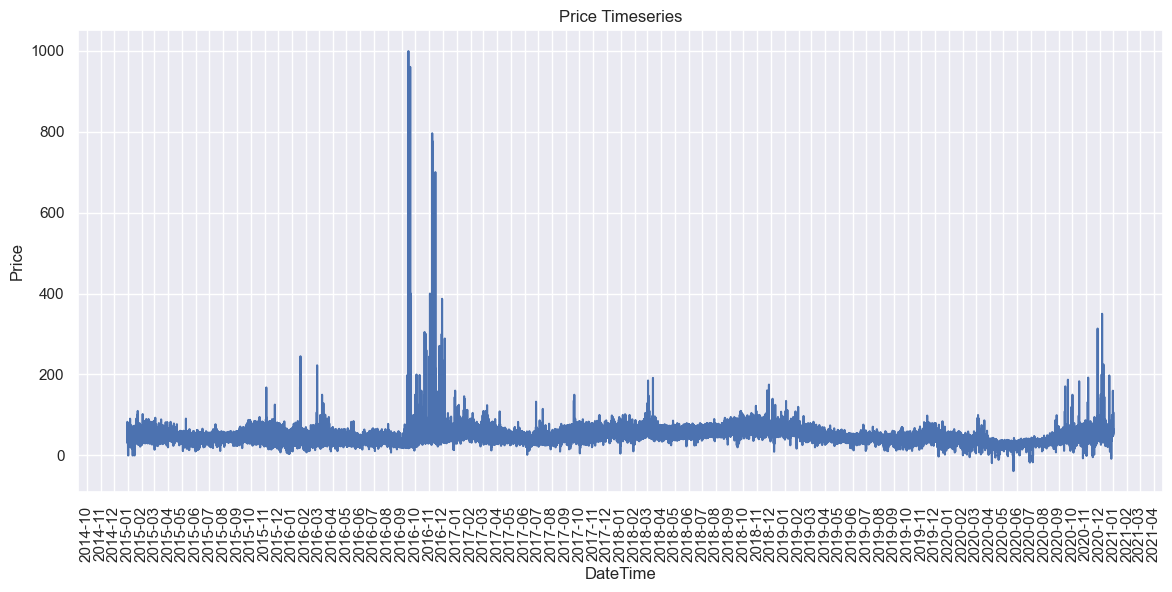

In [75]:
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=df_model.index, y=df_model['Price'], ax=ax)
month_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
plt.xticks(rotation=90)


plt.title('Price Timeseries')

Text(0.5, 1.0, 'Solar Generation Timeseries')

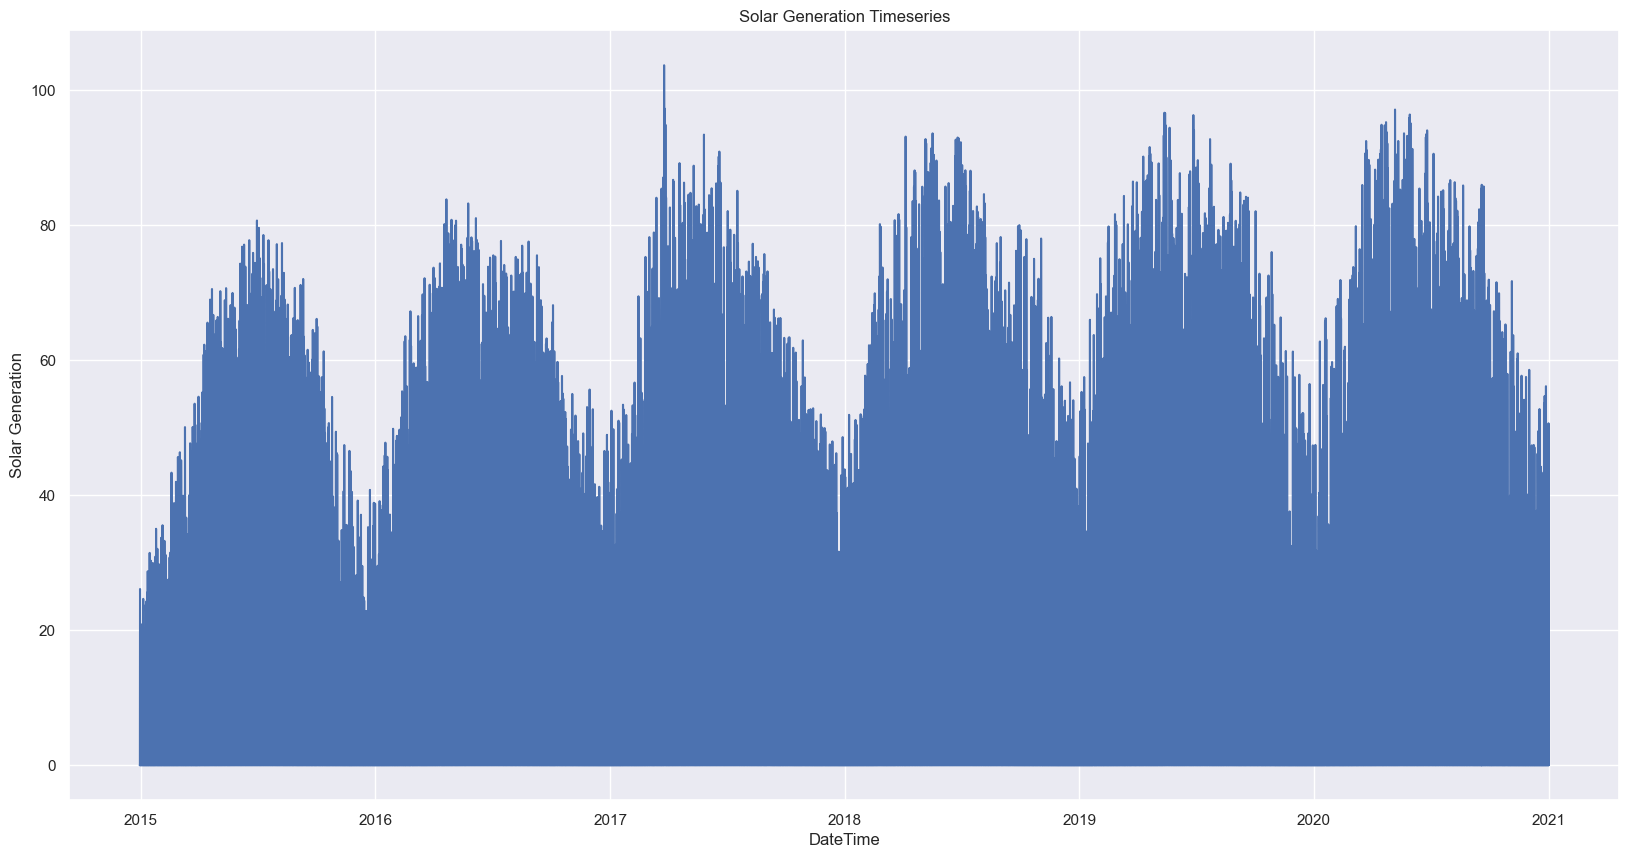

In [61]:
sns.lineplot(x=df_model.index, y=df_model['Solar Generation'])
plt.title('Solar Generation Timeseries')

Text(0.5, 1.0, 'Wind Offshore Generation Timeseries')

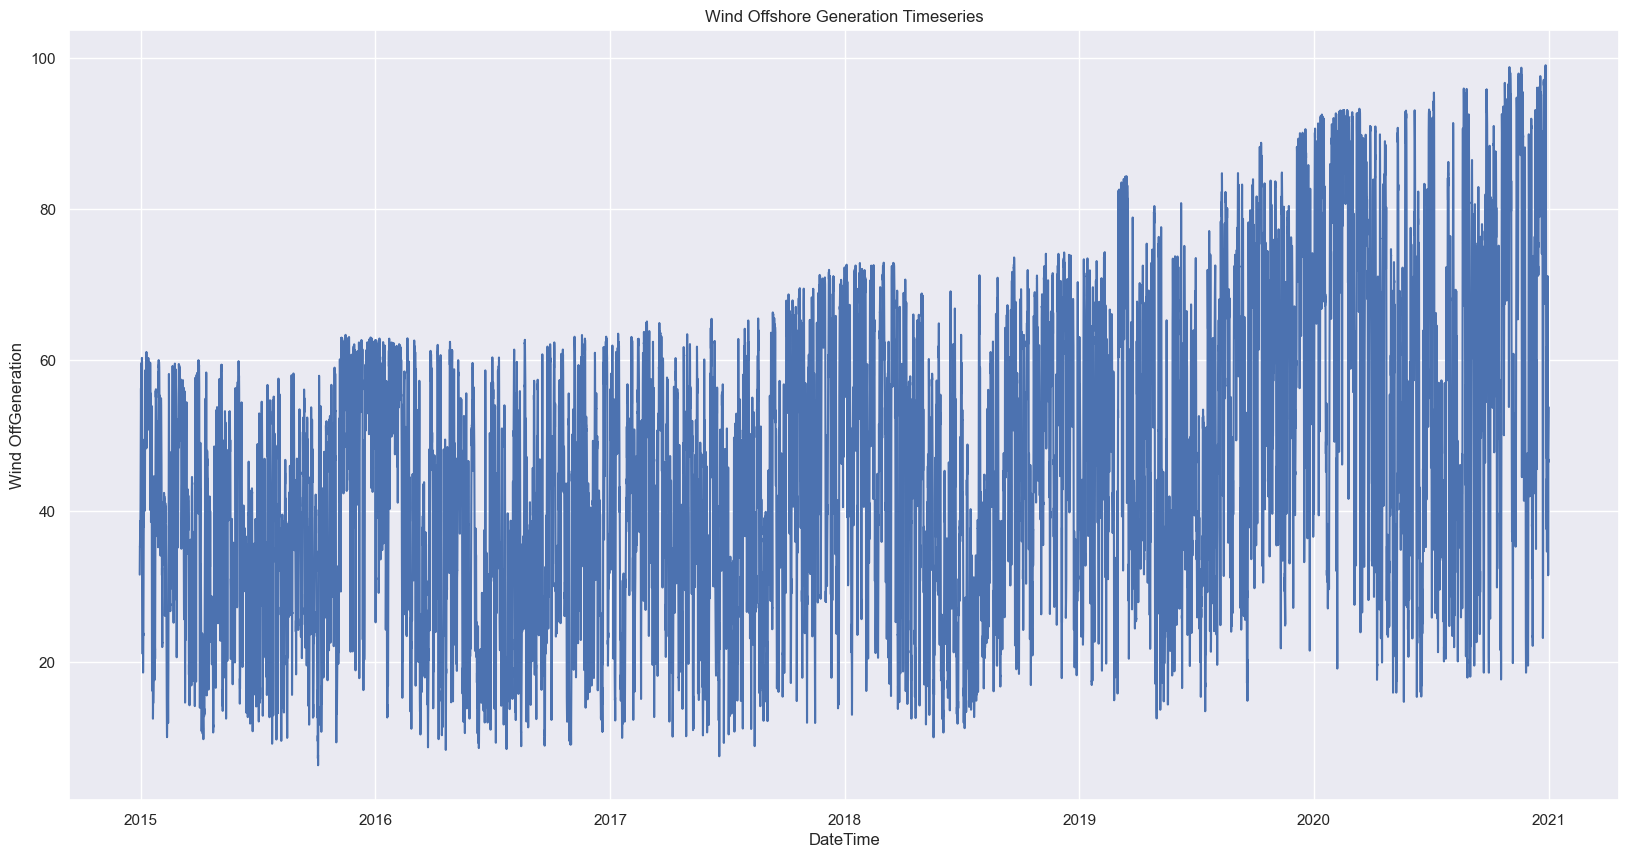

In [62]:
sns.lineplot(x=df_model.index, y=df_model['Wind OffGeneration'])
plt.title('Wind Offshore Generation Timeseries')

Text(0.5, 1.0, 'Wind Onshore Generation Timeseries')

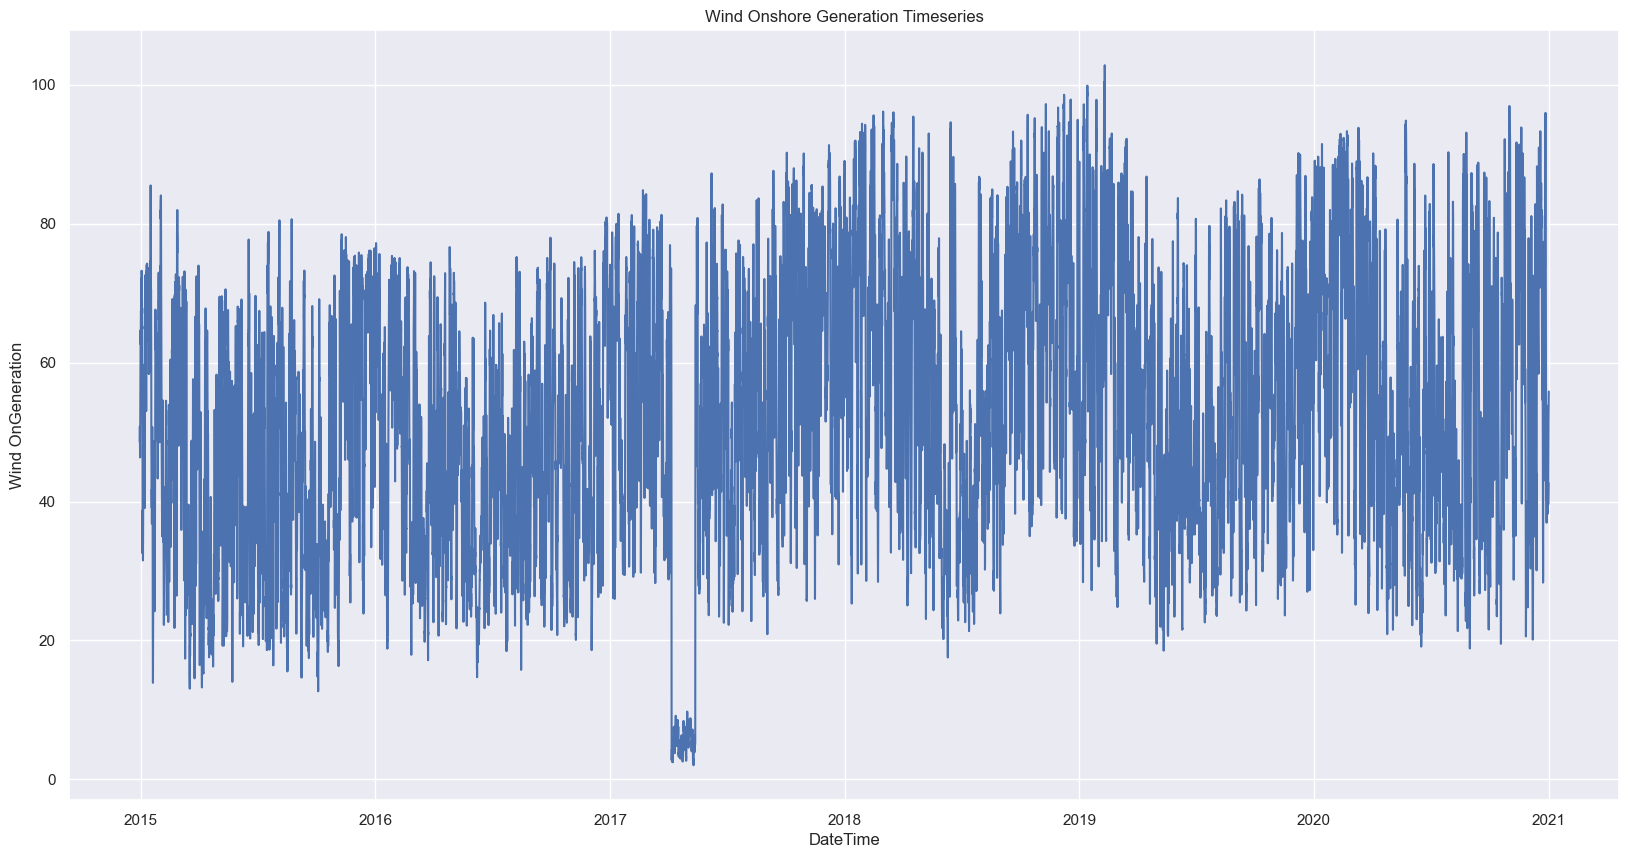

In [63]:
sns.lineplot(x=df_model.index, y=df_model['Wind OnGeneration'])
plt.title('Wind Onshore Generation Timeseries')

Text(0.5, 1.0, 'Demand Timeseries')

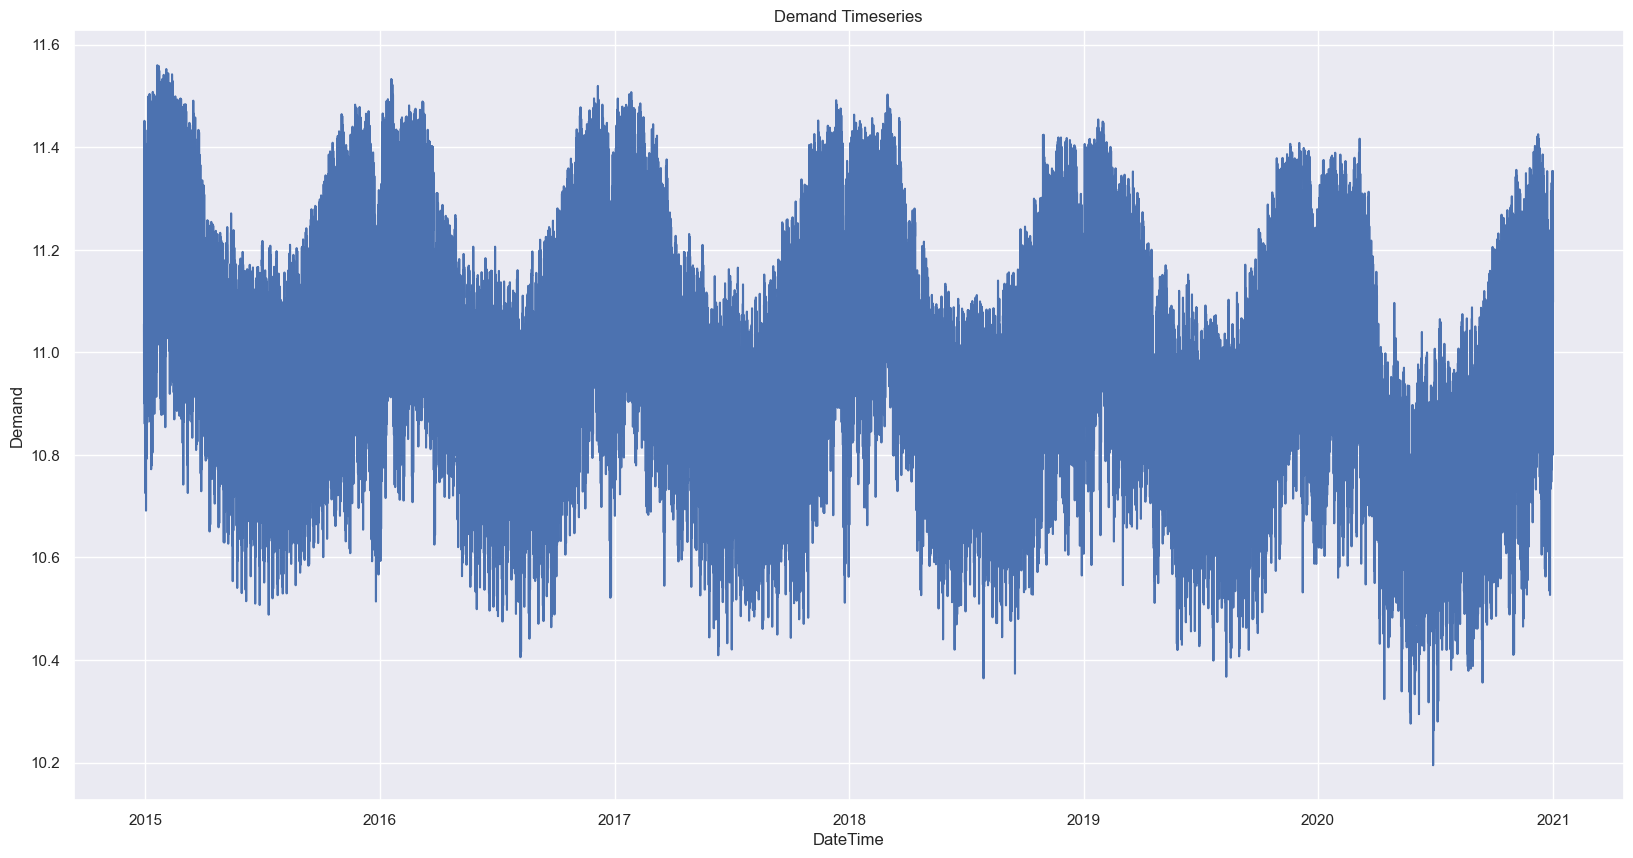

In [64]:
sns.lineplot(x=df_model.index, y=df_model['Demand'])
plt.title('Demand Timeseries')

In [76]:
# Selecting the timeseries we will study further on.

df_model = df_model.loc['2016-12-1':'2020-09-30']

In [78]:
len(df_model)

33600

# Creating lags - 1-week-lags

In [79]:
def lag_col(df, variable, lags):
    '''
        Takes in a pandas dataframe, a specific variable of the dataset and number of lags as a list
        and returns the df updated with the lags of the variable
        
        Parameters:
            df: pandas dataframe
            variable: string
            lags: list
        
        Returns:
            Adds column for every lag inside the list for our designated variable
        
        '''


    for lag in lags:
        df[str(variable) + '_' + str(lag)] = df[variable].shift(lag)
    return df

In [80]:
lags = list(range(1,168)) # 1-week-lags

In [81]:
lag_col(df_model, 'Price', lags)
lag_col(df_model, 'Solar Generation', lags)
lag_col(df_model, 'Wind OffGeneration', lags)
lag_col(df_model, 'Wind OnGeneration', lags)
lag_col(df_model, 'Demand', lags)

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_1,Price_2,Price_3,Price_4,Price_5,...,Demand_158,Demand_159,Demand_160,Demand_161,Demand_162,Demand_163,Demand_164,Demand_165,Demand_166,Demand_167
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-01 00:00:00,45.01,38.066521,61.022619,0.0,11.049095,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 01:00:00,42.09,39.561345,61.443063,0.0,11.012083,45.01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 02:00:00,39.59,40.062451,61.785921,0.0,10.997037,42.09,45.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 03:00:00,37.94,40.353067,62.417225,0.0,10.969542,39.59,42.09,45.01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 04:00:00,36.79,40.448115,62.600319,0.0,10.947450,37.94,39.59,42.09,45.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,46.55,88.165356,53.472516,0.0,11.185601,59.49,67.72,56.82,50.12,43.70,...,10.636600,10.580327,10.577579,10.602319,10.625538,10.663943,10.759965,10.886539,11.006158,11.109683
2020-09-30 20:00:00,40.95,88.390837,52.649786,0.0,11.119364,46.55,59.49,67.72,56.82,50.12,...,10.826158,10.636600,10.580327,10.577579,10.602319,10.625538,10.663943,10.759965,10.886539,11.006158
2020-09-30 21:00:00,34.84,87.631501,51.511164,0.0,11.025051,40.95,46.55,59.49,67.72,56.82,...,10.985733,10.826158,10.636600,10.580327,10.577579,10.602319,10.625538,10.663943,10.759965,10.886539


In [83]:
missing_zero_values_table(df_model)

Our selected dataframe has 840 columns and 33600 Rows.
There are 835 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Demand_167,0,167,0.5,167,0.5,float64
Price_167,9,167,0.5,176,0.5,float64
Wind OnGeneration_167,0,167,0.5,167,0.5,float64
Wind OffGeneration_167,0,167,0.5,167,0.5,float64
Solar Generation_167,14562,167,0.5,14729,43.8,float64
...,...,...,...,...,...,...
Solar Generation_1,14638,1,0.0,14639,43.6,float64
Demand_1,0,1,0.0,1,0.0,float64
Wind OffGeneration_1,0,1,0.0,1,0.0,float64
Wind OnGeneration_1,0,1,0.0,1,0.0,float64


In [84]:
# We are losing 167 hours, so these will be the first two weeks of December 2016

In [85]:
# Extracting the hours in a seperate column

df_model['Hour'] = df_model.index.hour
df_model

# Re-forming our dataset

## Creating single-hour data blocks

In [87]:
df_model.dropna(inplace=True) # Clearing na values

#Create multi-dataframe that will have every single dataset regarding the time of the day

hours = df_model['Hour'].unique().tolist()
df_hour ={hour: pd.DataFrame() for hour in hours}
for i in range(len(hours)):
    df_hour[i] = df_model[df_model['Hour'] == i]
    df_hour[i] = df_hour[i][(np.abs(stats.zscore(df_hour[i]['Price']))<3)]


# Example of the dataset of 00:00    
df_hour[0]


,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_1,Price_2,Price_3,Price_4,Price_5,...,Demand_159,Demand_160,Demand_161,Demand_162,Demand_163,Demand_164,Demand_165,Demand_166,Demand_167,Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-08,37.76,56.506548,68.892670,0.0,10.940685,37.92,36.46,38.20,48.32,56.22,...,11.385353,11.351900,11.171603,10.983596,10.930998,10.947450,10.969542,10.997037,11.012083,0
2016-12-09,40.44,30.872642,48.046644,0.0,10.984004,40.87,36.07,42.06,48.34,54.94,...,11.394649,11.354527,11.179060,11.003316,10.954484,10.971142,10.992167,11.022833,11.038014,0
2016-12-10,40.25,54.259654,64.034053,0.0,10.941412,43.58,34.24,35.94,43.98,49.46,...,11.184949,11.082881,10.974643,10.891857,10.883804,10.913414,10.950807,10.992083,11.018170,0
2016-12-11,40.93,44.436359,63.115687,0.0,10.917105,42.07,36.08,41.93,44.72,49.78,...,11.053205,10.958392,10.884198,10.828064,10.830896,10.867101,10.902114,10.946464,10.975995,0
2016-12-12,37.34,23.253602,33.923591,0.0,10.957625,37.41,40.09,49.93,49.90,55.77,...,11.409519,11.364982,11.177439,10.981727,10.923471,10.931588,10.948189,10.970076,10.975020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26,26.20,94.002819,70.416191,0.0,10.584942,28.71,31.80,33.14,42.97,54.00,...,10.791441,10.779748,10.700206,10.602095,10.505424,10.473506,10.484697,10.519268,10.545894,0
2020-09-27,16.95,88.261090,51.837535,0.0,10.579768,18.77,35.13,38.00,44.94,51.04,...,10.780830,10.733850,10.625028,10.540488,10.485787,10.468745,10.479258,10.507011,10.535849,0
2020-09-28,27.61,66.250132,34.901719,0.0,10.659680,28.85,31.38,36.65,41.23,50.00,...,11.030574,11.037966,10.984869,10.813358,10.626921,10.560800,10.554875,10.573033,10.594608,0


In [88]:
# Dropping unwanted features for every single dataset and dropping the nan values
for i in range(len(hours)):
    df_hour[i].drop(columns=['Hour'], inplace=True)
    # df_hour[i].dropna(inplace=True)

# Example of data frame regarding the 23:00 data frame
df_hour[23]

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_1,Price_2,Price_3,Price_4,Price_5,...,Demand_158,Demand_159,Demand_160,Demand_161,Demand_162,Demand_163,Demand_164,Demand_165,Demand_166,Demand_167
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-07 23:00:00,37.92,59.436857,71.683959,0.0,11.061343,36.46,38.20,48.32,56.22,60.46,...,11.385353,11.351900,11.171603,10.983596,10.930998,10.947450,10.969542,10.997037,11.012083,11.049095
2016-12-08 23:00:00,40.87,34.753561,51.147336,0.0,11.102292,36.07,42.06,48.34,54.94,59.95,...,11.394649,11.354527,11.179060,11.003316,10.954484,10.971142,10.992167,11.022833,11.038014,11.067372
2016-12-09 23:00:00,43.58,55.037623,67.413871,0.0,11.041048,34.24,35.94,43.98,49.46,55.95,...,11.184949,11.082881,10.974643,10.891857,10.883804,10.913414,10.950807,10.992083,11.018170,11.048999
2016-12-10 23:00:00,42.07,48.215247,65.037220,0.0,11.012182,36.08,41.93,44.72,49.78,61.10,...,11.053205,10.958392,10.884198,10.828064,10.830896,10.867101,10.902114,10.946464,10.975995,11.004829
2016-12-11 23:00:00,37.41,23.033454,34.565445,0.0,11.076449,40.09,49.93,49.90,55.77,70.00,...,11.409519,11.364982,11.177439,10.981727,10.923471,10.931588,10.948189,10.970076,10.975020,10.999664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26 23:00:00,18.77,91.102415,57.493826,0.0,10.672739,35.13,38.00,44.94,51.04,59.96,...,10.780830,10.733850,10.625028,10.540488,10.485787,10.468745,10.479258,10.507011,10.535849,10.582764
2020-09-27 23:00:00,28.85,68.280671,32.693730,0.0,10.743761,31.38,36.65,41.23,50.00,62.39,...,11.030574,11.037966,10.984869,10.813358,10.626921,10.560800,10.554875,10.573033,10.594608,10.617319
2020-09-28 23:00:00,36.10,35.669875,38.577973,0.0,10.782512,37.54,37.44,43.19,49.23,67.50,...,10.976013,10.994958,10.944100,10.812149,10.643089,10.587165,10.588729,10.611006,10.630819,10.664737


# Lasso - Garch Model

## Dataset Split

In [93]:
from sklearn.model_selection import train_test_split

# Splitting every dataset for our dependent and independent variables 




X_train = {hour: pd.DataFrame() for hour in hours}
y_train = {hour: pd.DataFrame() for hour in hours}
X_test = {hour: pd.DataFrame() for hour in hours}
y_test = {hour: pd.DataFrame() for hour in hours}

for hour in range(len(hours)):
    X_train[hour], X_test[hour], y_train[hour], y_test[hour] = train_test_split(df_hour[hour].drop(columns='Price'),
                                                                                df_hour[hour]['Price'],
                                                                                test_size=0.20,
                                                                                shuffle=False)



## Lasso Regressor and TimeSeriesSplit

In [94]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

# Creating the object that will be used during the cross-validation, with 5 folds
tscv = TimeSeriesSplit(n_splits=5)


# Create empty dataframes with hour as index in order to fill the trained models, and train them accordingly
model_test = {hour: pd.DataFrame() for hour in hours}
model_train = {hour: pd.DataFrame() for hour in hours}




# We will traing every model for every hour, and we generate a data frame that will inform us about the r-squared,
# alpha value and intercept for every model

rsquared_test = []
rsquared_train = []
model_name = []


for hour in hours:
    model_train[hour] = LassoCV(cv=tscv, random_state=0).fit(X_train[hour],y_train[hour])
    model_test[hour] = LassoCV(cv=tscv, random_state=0).fit(X_test[hour],y_test[hour])
    rsquared_train.append(model_train[hour].score(X_train[hour], y_train[hour]))
    rsquared_test.append(model_test[hour].score(X_test[hour], y_test[hour]))

    model_name.append('model[' + str(hour) + ']')

model_results = pd.DataFrame(columns=['Model', 'Rsquared Value Train', 'Rsquared Value Test'])
model_results['Model'] = model_name
model_results['Rsquared Value Train'] = rsquared_train
model_results['Rsquared Value Test'] = rsquared_test



# Table that shows the results for every trained model
model_results

,Model,Rsquared Value Train,Rsquared Value Test
0,model[23],0.832303,0.709473
1,model[0],0.914334,0.906861
2,model[1],0.925240,0.939639
3,model[2],0.938575,0.937570
4,model[3],0.947351,0.955845
5,model[4],0.927081,0.890748
6,model[5],0.900152,0.888457
7,model[6],0.826333,0.908903
8,model[7],0.829534,0.876792
9,model[8],0.874596,0.918609


In [128]:
# Create multi data frame that will inform us about its coefficients with a descending order

df_coef = {hour: pd.DataFrame() for hour in hours}
for hour in hours:
    df_coef[hour].index = X_train[hour].transpose().index
    df_coef[hour]['Coefficients'] = model_train[hour].coef_.transpose()
    df_coef[hour].sort_values(by='Coefficients', ascending=False, inplace=True)
    df_coef[hour]

# Example of coefficient table of our top 10 coefficients for hour 8:00
a = df_coef[8].head(10)
a


,Coefficients
Price_1,0.675729
Price_167,0.101042
Price_23,0.082197
Price_10,0.049534
Price_89,0.038663
Price_18,0.037878
Solar Generation_111,0.036202
Price_24,0.028879
Price_16,0.018015
Wind OnGeneration_163,0.011496


Text(0.5, 0, 'Coefficients')

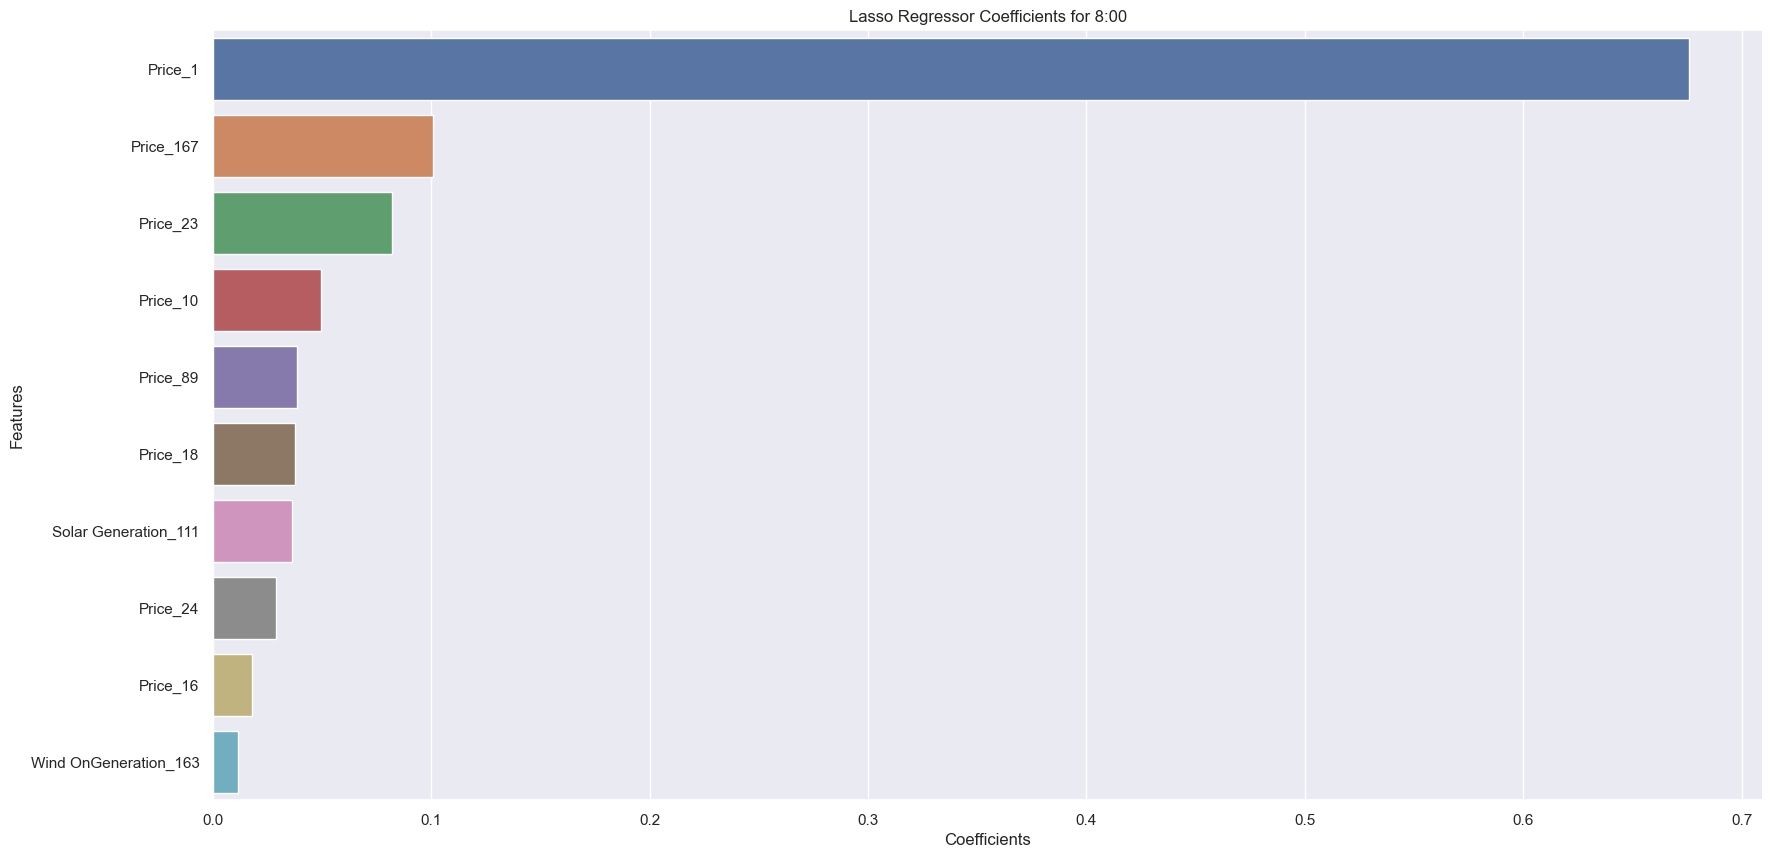

In [129]:
# Barplot for top 10 coeffiecients (features) for hour 8:00

sns.barplot(x=a['Coefficients'],y=a.index )
plt.title('Lasso Regressor Coefficients for 8:00')
plt.ylabel('Features')
plt.xlabel('Coefficients')

In [97]:
# Create multi data frame that will provides us with the residuals and squared residuals for every trained model, 
# for every hour


lasso_train = {hour: pd.DataFrame() for hour in hours}
lasso_test = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    lasso_train[hour] = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
    lasso_train[hour]['Actual Value'] = y_train[hour]
    lasso_train[hour]['Predicted Value'] = model_train[hour].predict(X_train[hour])
    lasso_train[hour]['Residual'] = lasso_train[hour]['Actual Value'] - lasso_train[hour]['Predicted Value']
    lasso_train[hour]['Squared Residuals'] = lasso_train[hour]['Residual'].mul(lasso_train[hour]['Residual'])

for hour in hours:
    lasso_test[hour] = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
    lasso_test[hour]['Actual Value'] = y_test[hour]
    lasso_test[hour]['Predicted Value'] = model_train[hour].predict(X_test[hour])
    lasso_test[hour]['Residual'] = lasso_test[hour]['Actual Value'] - lasso_test[hour]['Predicted Value']
    lasso_test[hour]['Squared Residuals'] = lasso_test[hour]['Residual'].mul(lasso_test[hour]['Residual'])


# Example of the table
lasso_train[18]

,Actual Value,Predicted Value,Residual,Squared Residuals
DateTime,,,,
2016-12-08 18:00:00,59.95,62.124669,-2.174669,4.729185
2016-12-09 18:00:00,55.95,50.606829,5.343171,28.549474
2016-12-10 18:00:00,61.10,63.673529,-2.573529,6.623052
2016-12-11 18:00:00,70.00,69.011537,0.988463,0.977060
2016-12-12 18:00:00,67.63,74.986380,-7.356380,54.116327
...,...,...,...,...
2019-12-23 18:00:00,54.54,51.283763,3.256237,10.603082
2019-12-24 18:00:00,45.60,47.920852,-2.320852,5.386352
2019-12-25 18:00:00,36.70,48.069394,-11.369394,129.263129


## Garch Model

## Working an example

In [98]:
from arch import arch_model

# Using arch_lasso_exp as an example, variable b takes an int number pointing the hour 
# we want to produce the arch model

b = 22

arch_lasso_exp = arch_model(lasso_train[b]['Residual'], vol='GARCH', p=1,q=1, dist='normal', mean='zero')
arch_lasso_exp = arch_lasso_exp.fit()
arch_lasso_exp.summary()
arch_lasso_exp.forecast(horizon=len(lasso_test[b])).variance.values[-1, :]

Iteration:      1,   Func. Count:      5,   Neg. LLF: 6032.990473899178
Iteration:      2,   Func. Count:     12,   Neg. LLF: 438739.7910817511
Iteration:      3,   Func. Count:     17,   Neg. LLF: 3054.9496504173044
Iteration:      4,   Func. Count:     22,   Neg. LLF: 4313.917737032387
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3056.901622062387
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3051.8981242994328
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3051.8676719257114
Iteration:      8,   Func. Count:     42,   Neg. LLF: 3051.867595568212
Iteration:      9,   Func. Count:     45,   Neg. LLF: 3051.8675955684726
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3051.867595568212
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


array([ 7.49924632,  7.66056729,  7.81979203,  7.97694778,  8.13206142,
        8.28515949,  8.43626818,  8.58541333,  8.73262047,  8.87791478,
        9.02132111,  9.162864  ,  9.30256765,  9.44045597,  9.57655255,
        9.71088066,  9.8434633 ,  9.97432314, 10.10348256, 10.23096366,
       10.35678825, 10.48097786, 10.60355373, 10.72453683, 10.84394785,
       10.96180723, 11.07813512, 11.19295143, 11.3062758 , 11.41812762,
       11.52852601, 11.63748987, 11.74503783, 11.8511883 , 11.95595943,
       12.05936915, 12.16143515, 12.26217488, 12.36160559, 12.45974428,
       12.55660773, 12.65221253, 12.74657502, 12.83971136, 12.93163746,
       13.02236906, 13.11192168, 13.20031064, 13.28755106, 13.37365786,
       13.45864578, 13.54252935, 13.62532292, 13.70704066, 13.78769655,
       13.86730438, 13.94587777, 14.02343017, 14.09997484, 14.17552488,
       14.2500932 , 14.32369258, 14.39633559, 14.46803466, 14.53880207,
       14.60864992, 14.67759015, 14.74563455, 14.81279478, 14.87

Text(0.5, 1.0, 'Volatility for 22:00')

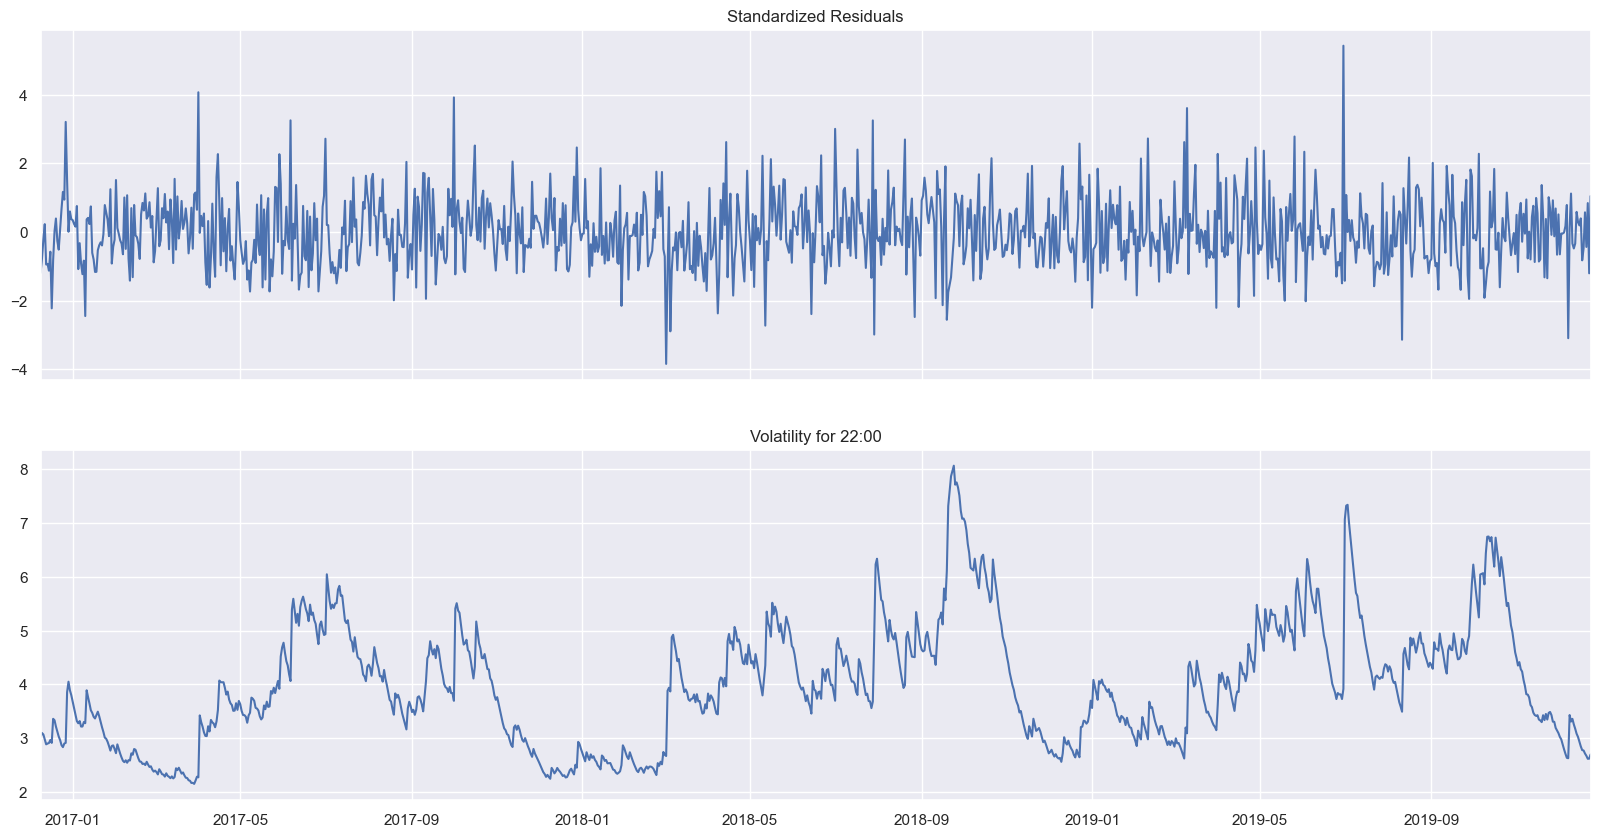

In [99]:
# Producing conditional volatility plot for our garch model

arch_lasso_exp.plot();
plt.title('Volatility for ' + str(b) + ':00')


Text(0.5, 1.0, 'Distribution of Standardized Residuals for GARCH(1,1) - 22:00')

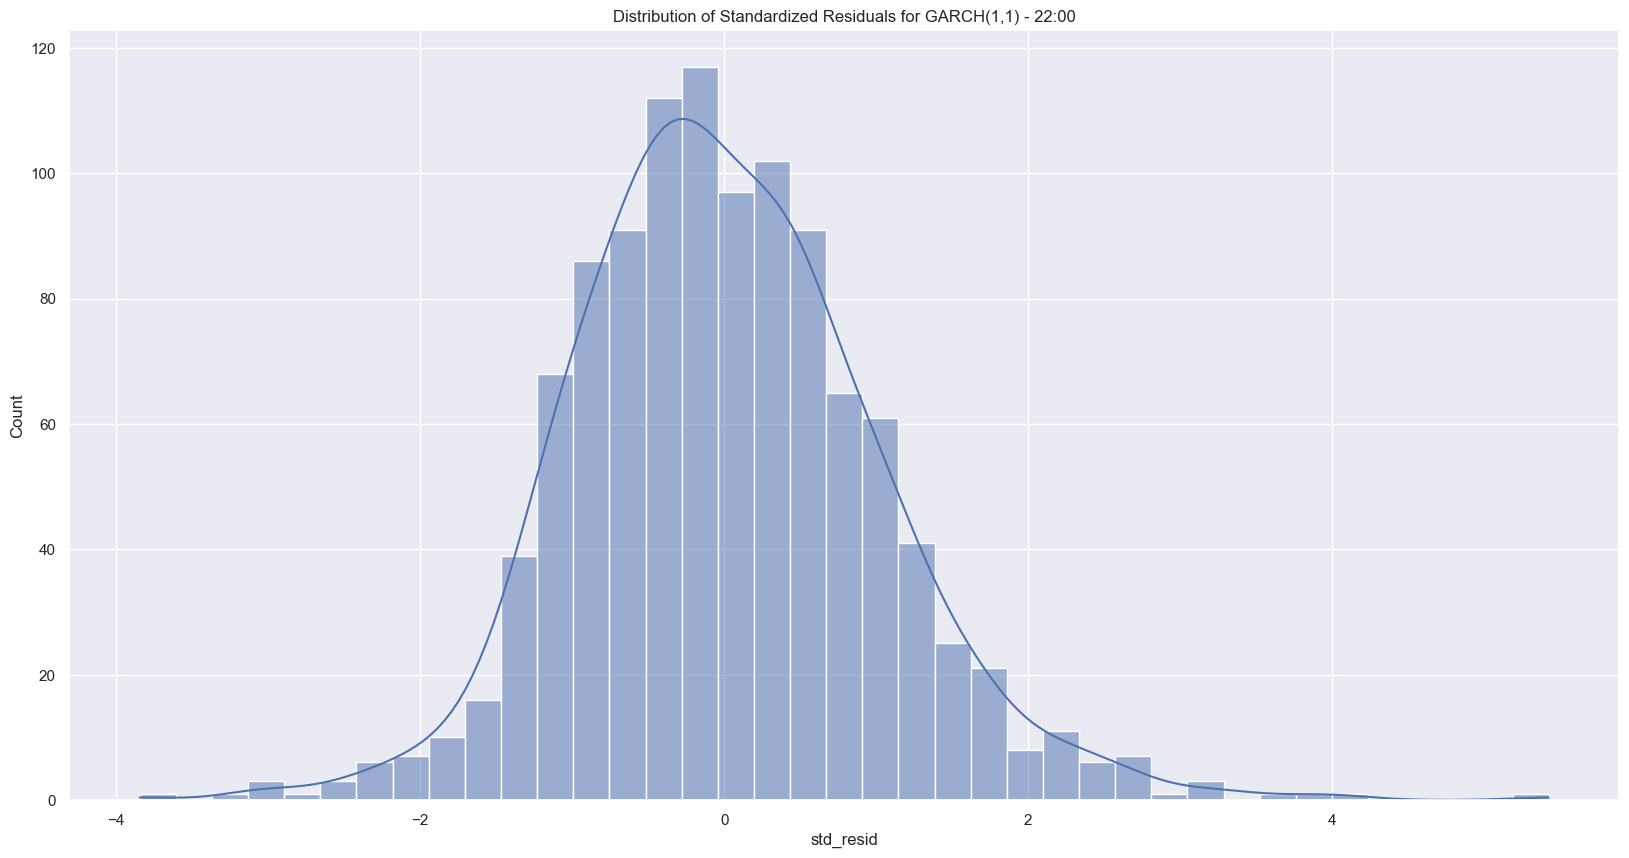

In [100]:
# Plotting the standardized residuals of our garch model

sns.histplot(arch_lasso_exp.std_resid, kde=True)
plt.title('Distribution of Standardized Residuals for GARCH(1,1) - ' + str(b) + ':00')

Text(0.5, 1.0, 'QQplot for Standardized Residuals - GARCH(1,1) 22:00')

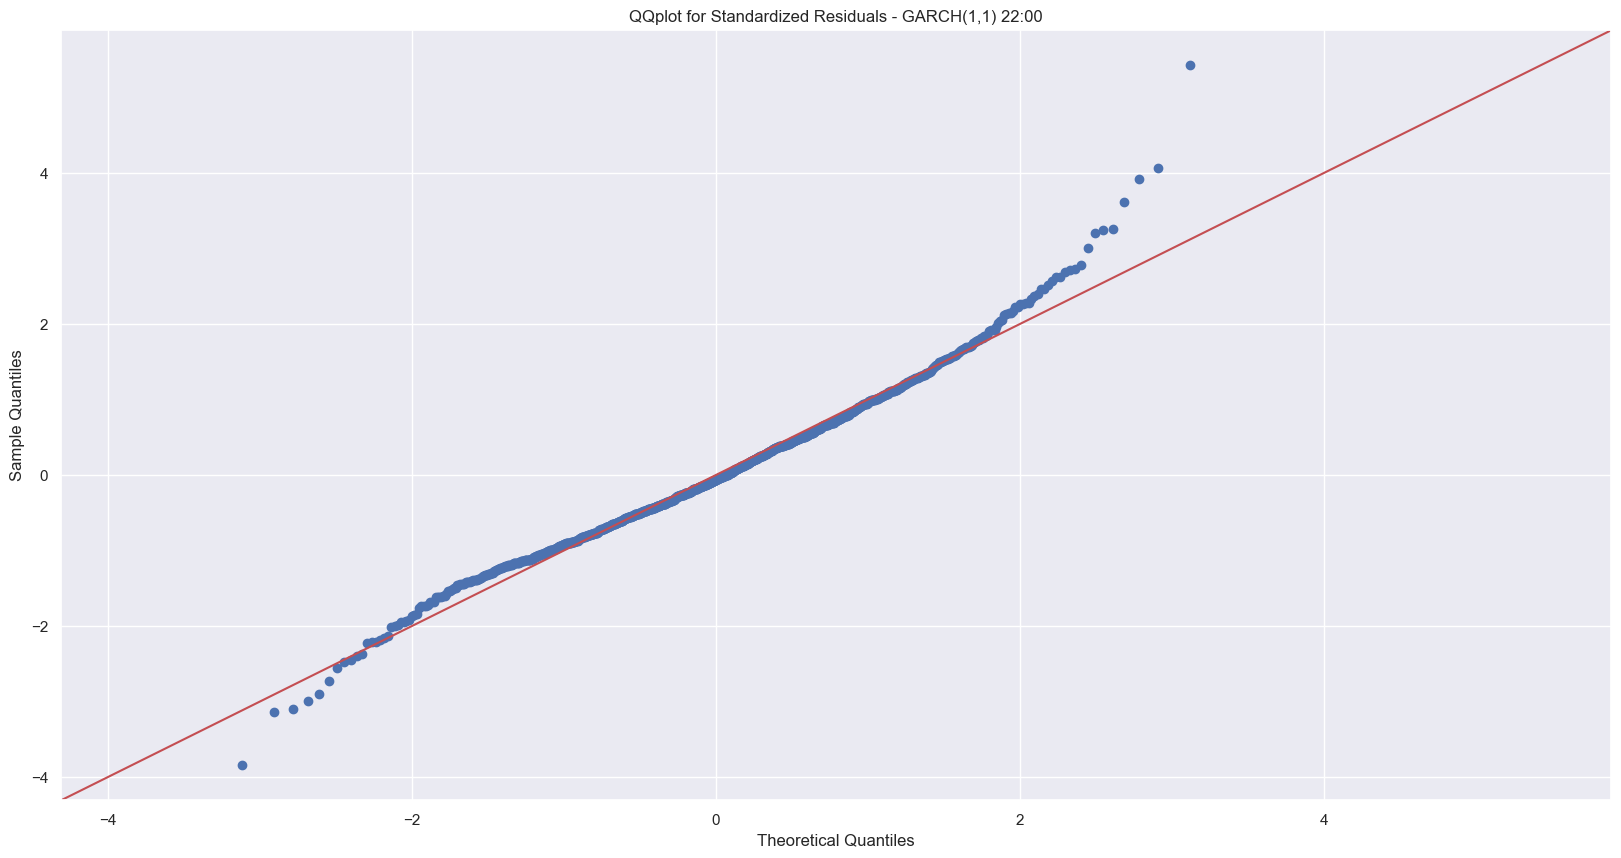

In [101]:
# Plotting the qqplot of our standardized residuals

import statsmodels.api as sm
import pylab

x = arch_lasso_exp.std_resid
sm.qqplot(x, line='45')

plt.title('QQplot for Standardized Residuals - GARCH(1,1) ' + str(b) + ':00')

## Training every model

In [102]:
# Training every garch model for every hour ( takes the residuals from our trained lasso models)

from scipy import stats
garch_lasso_train = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    garch_lasso_train[hour] = arch_model(lasso_train[hour]['Residual'], vol='GARCH', p=1,q=1, mean='zero').fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5628.04096257618
Iteration:      2,   Func. Count:     11,   Neg. LLF: 3108.468817797265
Iteration:      3,   Func. Count:     16,   Neg. LLF: 3084.8249313520473
Iteration:      4,   Func. Count:     21,   Neg. LLF: 3083.5217658347256
Iteration:      5,   Func. Count:     25,   Neg. LLF: 3083.5105718996765
Iteration:      6,   Func. Count:     29,   Neg. LLF: 3083.5084912810444
Iteration:      7,   Func. Count:     33,   Neg. LLF: 3083.506866723972
Iteration:      8,   Func. Count:     37,   Neg. LLF: 3083.5068614515967
Iteration:      9,   Func. Count:     40,   Neg. LLF: 3083.506861451511
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3083.5068614515967
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2847.4864811882394
Iteration:      2,   Func. Count:     11,   Neg. LLF: 5258.87669901

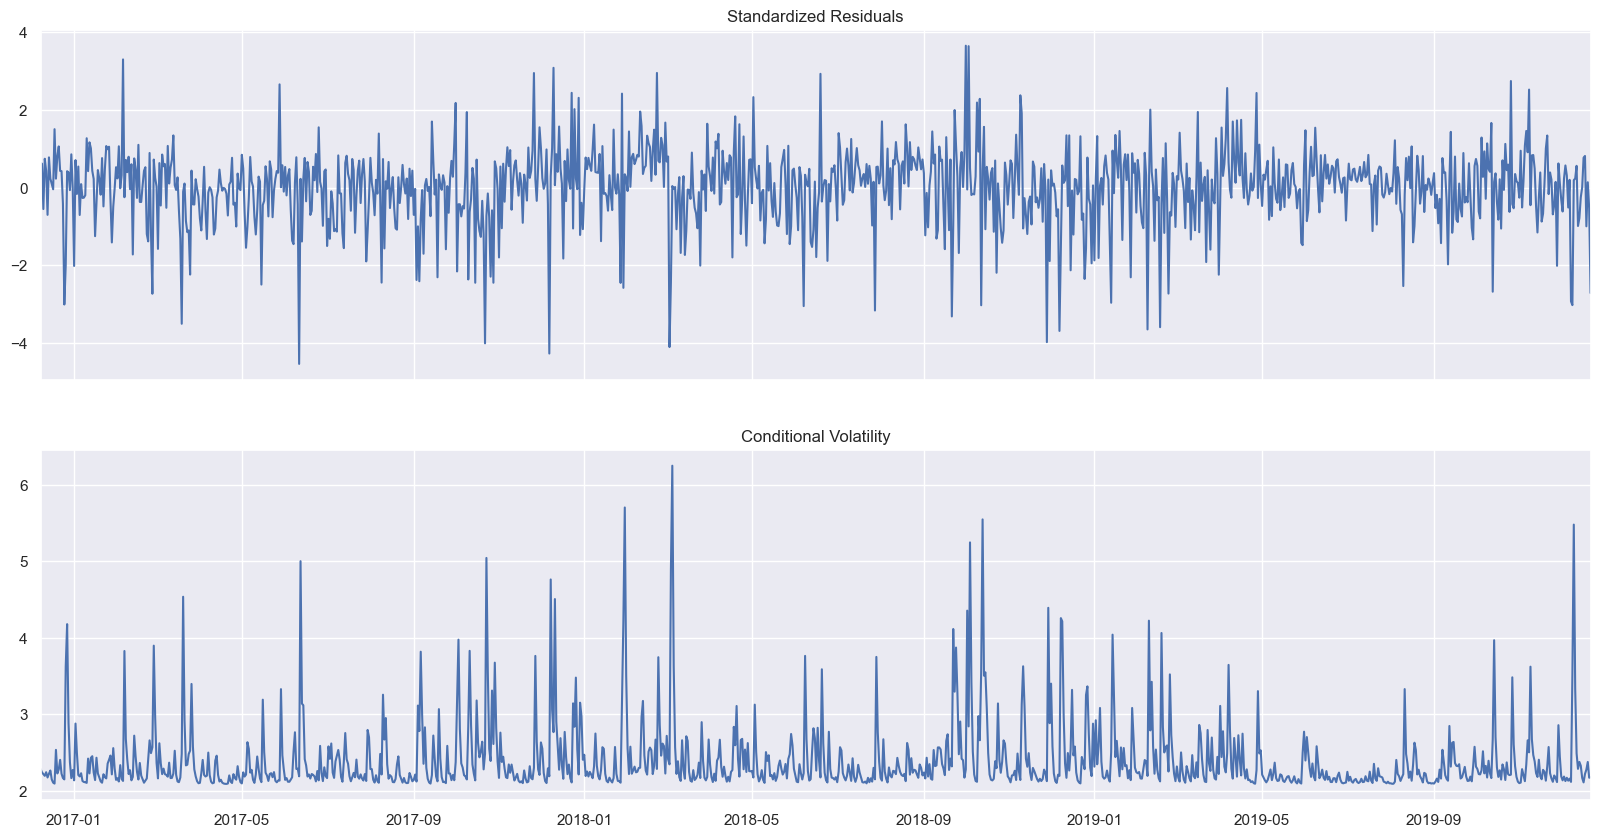

In [103]:
fig = garch_lasso_train[2].plot()

In [104]:
garch_lasso_results = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    garch_lasso_results[hour]['Actual Value'] = lasso_test[hour]['Actual Value']
    garch_lasso_results[hour]['Predicted Value'] = lasso_test[hour]['Predicted Value']
    garch_lasso_results[hour]['Residual'] = lasso_test[hour]['Residual']
    garch_lasso_results[hour]['Squared Residuals'] = lasso_test[hour]['Squared Residuals']
    garch_lasso_results[hour]['STD'] = np.sqrt(garch_lasso_train[hour].forecast(horizon=len(lasso_test[hour])).variance.values[-1, :])
    

In [107]:
garch_lasso_results[5]

,Actual Value,Predicted Value,Residual,Squared Residuals,STD
DateTime,,,,,
2019-12-22 05:00:00,28.00,28.820489,-0.820489,0.673203,3.399678
2019-12-23 05:00:00,20.28,10.865781,9.414219,88.627512,3.398810
2019-12-24 05:00:00,34.41,34.936563,-0.526563,0.277269,3.397952
2019-12-25 05:00:00,22.22,22.359820,-0.139820,0.019550,3.397106
2019-12-26 05:00:00,18.20,16.417097,1.782903,3.178742,3.396270
...,...,...,...,...,...
2020-09-26 05:00:00,28.92,34.048947,-5.128947,26.306099,3.334402
2020-09-27 05:00:00,24.96,28.467489,-3.507489,12.302478,3.334377
2020-09-28 05:00:00,49.66,50.824272,-1.164272,1.355529,3.334352


# Lasso with constant standard deviation

In [130]:
# Residual and STD functions need attention

lasso_mean_results = {hour: pd.DataFrame() for hour in hours}
for hour in hours:
    lasso_mean_results[hour]['Actual Value'] = lasso_test[hour]['Actual Value']
    lasso_mean_results[hour]['Predicted Value'] = lasso_test[hour]['Predicted Value']
    lasso_mean_results[hour]['Error'] = lasso_test[hour]['Actual Value'] - lasso_test[hour]['Predicted Value']
    lasso_mean_results[hour]['Squared Errors'] = lasso_test[hour]['Squared Residuals']
    lasso_mean_results[hour]['STD'] = np.sqrt(1+(1/len(lasso_train[hour])))*np.sqrt((1/(len(lasso_train[hour]-1)))*np.sum(lasso_train[hour]['Residual'].mul(lasso_train[hour]['Residual'])))*np.sqrt(1+(1/(len(lasso_train[hour]))))

In [131]:
lasso_mean_results[4]

,Actual Value,Predicted Value,Error,Squared Errors,STD
DateTime,,,,,
2019-12-20 04:00:00,25.59,23.556275,2.033725,4.136037,2.533959
2019-12-21 04:00:00,26.91,24.816856,2.093144,4.381252,2.533959
2019-12-22 04:00:00,28.58,29.988640,-1.408640,1.984266,2.533959
2019-12-23 04:00:00,2.14,19.481516,-17.341516,300.728181,2.533959
2019-12-24 04:00:00,32.40,30.373416,2.026584,4.107045,2.533959
...,...,...,...,...,...
2020-09-26 04:00:00,25.82,29.411459,-3.591459,12.898576,2.533959
2020-09-27 04:00:00,16.83,21.448659,-4.618659,21.332006,2.533959
2020-09-28 04:00:00,42.00,34.087045,7.912955,62.614851,2.533959


# Lasso - ARIMA Model

In [307]:
# import statsmodels.api as sm
# import pmdarima as pm

## Trainning ARIMA and Parameter Estimation

In [308]:
# arima_train = {hour: pd.DataFrame() for hour in hours}
# arima_order = {hour: pd.DataFrame() for hour in hours}

# arima_hour = []
# arima_pqd = []

# for hour in hours:
#     arima_train[hour] = pm.auto_arima(lasso_train[hour]['Residual'],
#                                       test='adf',
#                                       suppress_warnings=True,
#                                       stepwise=True,
#                                       seasonal=True,
#                                       trace=False,
#                                       information_criterion='aic')
#     arima_hour.append('Arima on hour: '+ str(hour))
#     arima_pqd.append(arima_train[hour].order)


{0:                  Name      Order
 0    Arima on hour: 0  (1, 0, 1)
 1    Arima on hour: 1  (1, 0, 3)
 2    Arima on hour: 2  (1, 0, 1)
 3    Arima on hour: 3  (1, 0, 1)
 4    Arima on hour: 4  (2, 0, 1)
 5    Arima on hour: 5  (1, 0, 0)
 6    Arima on hour: 6  (2, 0, 2)
 7    Arima on hour: 7  (1, 0, 2)
 8    Arima on hour: 8  (5, 0, 2)
 9    Arima on hour: 9  (1, 0, 1)
 10  Arima on hour: 10  (1, 0, 0)
 11  Arima on hour: 11  (2, 0, 2)
 12  Arima on hour: 12  (3, 0, 3)
 13  Arima on hour: 13  (0, 0, 0)
 14  Arima on hour: 14  (0, 0, 0)
 15  Arima on hour: 15  (2, 0, 3)
 16  Arima on hour: 16  (1, 0, 1)
 17  Arima on hour: 17  (5, 0, 5)
 18  Arima on hour: 18  (2, 0, 2)
 19  Arima on hour: 19  (1, 0, 1)
 20  Arima on hour: 20  (1, 0, 1)
 21  Arima on hour: 21  (1, 0, 1)
 22  Arima on hour: 22  (1, 0, 1)
 23  Arima on hour: 23  (1, 0, 1),
 1:                  Name      Order
 0    Arima on hour: 0  (1, 0, 1)
 1    Arima on hour: 1  (1, 0, 3)
 2    Arima on hour: 2  (1, 0, 1)
 3    A

In [309]:
# lasso_arima_results = {hour: pd.DataFrame() for hour in hours}
# arima_forecast = {hour: pd.DataFrame() for hour in hours}

# for hour in hours:
#     arima_forecast[hour] = arima_train[hour].predict(n_periods=len(lasso_test[hour]))

# for hour in hours:
#     lasso_arima_results[hour]['Actual Value'] = lasso_test[hour]['Actual Value']
#     lasso_arima_results[hour]['Predicted Mean Value'] = lasso_test[hour]['Predicted Value']
#     lasso_arima_results[hour]['Predicted Residual'] = arima_forecast[hour]
#     lasso_arima_results[hour]['Predicted Value'] = lasso_arima_results[hour]['Predicted Mean Value'] + lasso_arima_results[hour]['Predicted Residual']
#     lasso_arima_results[hour]['Error'] = lasso_arima_results[hour]['Actual Value'] - lasso_arima_results[hour]['Predicted Value']
#     lasso_arima_results[hour]['STD'] = np.sqrt(1+(1/len(lasso_arima_results[hour])))*np.sqrt((1/(len(lasso_arima_results[hour])-1))*np.sum(lasso_arima_results[hour]['Error'].mul(lasso_arima_results[hour]['Error'])))


In [310]:
# lasso_arima_results[7]

,Actual Value,Predicted Mean Value,Predicted Residual,Predicted Value,Error,STD
DateTime,,,,,,
2020-01-02 07:00:00,36.90,31.315910,-1.286351e-01,31.187275,5.712725,4.644412
2020-01-03 07:00:00,35.43,33.831454,1.610508e-03,33.833064,1.596936,4.644412
2020-01-04 07:00:00,26.51,24.493629,1.554855e-03,24.495184,2.014816,4.644412
2020-01-05 07:00:00,28.09,25.637117,1.501126e-03,25.638618,2.451382,4.644412
2020-01-06 07:00:00,37.20,32.982188,1.449254e-03,32.983637,4.216363,4.644412
...,...,...,...,...,...,...
2020-12-27 07:00:00,8.22,8.448450,6.097204e-09,8.448450,-0.228450,4.644412
2020-12-28 07:00:00,45.23,54.240219,5.886511e-09,54.240219,-9.010219,4.644412
2020-12-29 07:00:00,50.16,54.102065,5.683098e-09,54.102065,-3.942065,4.644412


# SKTIME demo

In [189]:
import pmdarima as pm

In [198]:
X_train[1][['Solar Generation', 'Demand']]

,Solar Generation,Demand
DateTime,,
2016-12-08 01:00:00,0.0,10.908631
2016-12-09 01:00:00,0.0,10.943711
2016-12-10 01:00:00,0.0,10.912576
2016-12-11 01:00:00,0.0,10.885510
2016-12-12 01:00:00,0.0,10.929296
...,...,...
2019-12-16 01:00:00,0.0,10.835179
2019-12-17 01:00:00,0.0,10.947256
2019-12-18 01:00:00,0.0,10.959958


In [201]:
arima_model = pm.auto_arima(y=y_train[0],
                            x=X_train[0][['Solar Generation', 'Demand', 'Wind OffGeneration', 'Wind OnGeneration']],
                            test='adf',
                            information_criterion='aic',
                            seasonal=True)

In [204]:
arima_residuals = arima_model.arima_res_.resid

In [208]:
import statsmodels.api as sm

<AxesSubplot:ylabel='Count'>

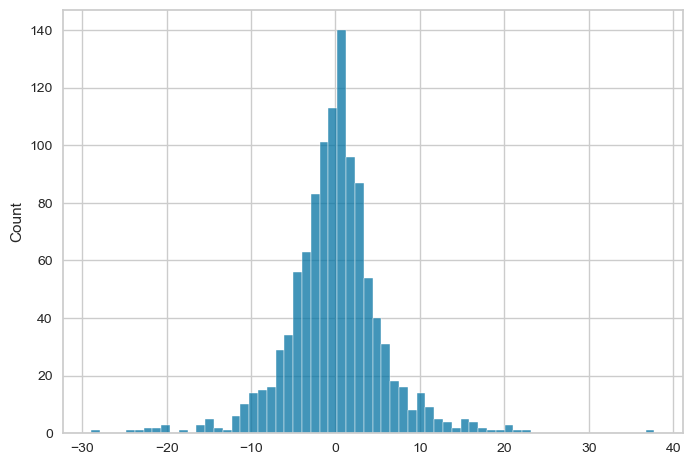

In [205]:
sns.histplot(arima_residuals)

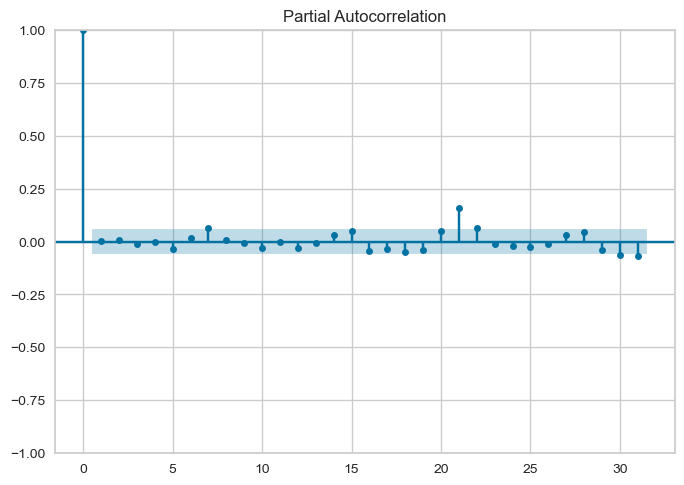

In [211]:
sm.graphics.tsa.plot_pacf(arima_residuals);

In [218]:
len(y_test[0])

277

In [223]:
garch = arch_model(arima_residuals,
                   p=1,
                   q=1)
garch_fitted = garch.fit()
predicted_mu = arima_model.predict(n_periods=len(y_test[0]))
garch_forecast = garch_fitted.forecast(horizon=277).variance.values[-1, :]

In [226]:
test_std = np.sqrt(garch_forecast)
test_mu = predicted_mu

In [233]:
y_test[0]

DateTime
2019-12-22    47.00
2019-12-23    35.20
2019-12-24    40.54
2019-12-25    27.93
2019-12-26    49.97
              ...  
2020-09-26    26.20
2020-09-27    16.95
2020-09-28    27.61
2020-09-29    34.37
2020-09-30    38.83
Name: Price, Length: 277, dtype: float64

In [230]:
len(test_std)

277

In [236]:
test = pd.DataFrame(columns=['Actual Value','Mean Value','STD'])

test['Actual Value'] = y_test[0]
test['Mean Value'] = test_mu
test['STD'] = test_std

,Actual Value,Mean Value,STD
DateTime,,,
2019-12-22,47.00,34.204319,8.674171
2019-12-23,35.20,33.427075,7.534346
2019-12-24,40.54,33.358393,6.820672
2019-12-25,27.93,33.352324,6.390662
2019-12-26,49.97,33.351788,6.139241
...,...,...,...
2020-09-26,26.20,33.351736,5.811095
2020-09-27,16.95,33.351736,5.811095
2020-09-28,27.61,33.351736,5.811095


# Evaluation Metrics

## Reliability Diagrams

In [118]:
from ProbEval import reliability_diagram

In [126]:
h = 15

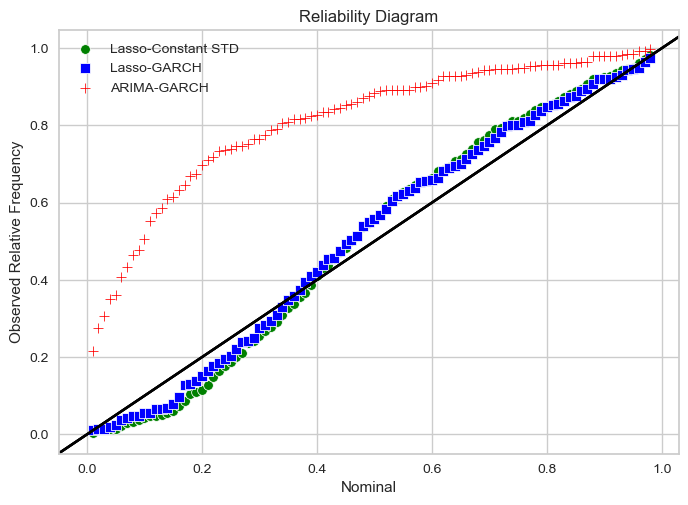

In [238]:
%load_ext autoreload

%autoreload 2

# reliability_diagram(lasso_arima_results[h],
#                     obs='Actual Value',
#                     mu='Predicted Value',
#                     std='STD',
#                     plot=True,
#                     c='red',
#                     l='Lasso-ARIMA',
#                     m='o')
reliability_diagram(lasso_mean_results[h],
                    obs='Actual Value',
                    mu='Predicted Value',
                    std='STD',
                    plot=True,
                    c='green',
                    l='Lasso-Constant STD',
                    m='o')
reliability_diagram(garch_lasso_results[h],
                    obs='Actual Value',
                    mu='Predicted Value',
                    std='STD',
                    plot=True,
                    c='blue',
                    l='Lasso-GARCH',
                    m='s')
reliability_diagram(df=test,
                    obs='Actual Value',
                    mu='Mean Value',
                    std='STD',
                    plot=True,
                    c='red',
                    l='ARIMA-GARCH')

## CRPS

In [314]:
from ProbEval import crps_norm

In [315]:
crps_score_table = pd.DataFrame(columns=('Model', 'LASSO-GARCH CRPS', 'LASSO Benchmark CRPS', 'LASSO-ARIMA CRPS'))
lasso_garch_crps = {hour: pd.DataFrame() for hour in hours}
lasso_mean_crps = {hour: pd.DataFrame() for hour in hours}
lasso_arima_crps = {hour: pd.DataFrame() for hour in hours}

l_g_crps = []
l_m_crps = []
l_a_crps = []
h = []


for hour in hours:
    lasso_garch_crps[hour] = crps_norm(garch_lasso_results[hour],
                                 obs='Actual Value',
                                 m='Predicted Value',
                                 sigma='STD')
    l_g_crps.append(np.mean(lasso_garch_crps[hour]))

    lasso_mean_crps[hour] = crps_norm(lasso_mean_results[hour],
                                      obs='Actual Value',
                                      m='Predicted Value',
                                      sigma='STD')
    l_m_crps.append(np.mean(lasso_mean_crps[hour]))

    lasso_arima_crps[hour] = crps_norm(lasso_arima_results[hour],
                                       obs='Actual Value',
                                       m='Predicted Value',
                                       sigma='STD')
    l_a_crps.append(np.mean(lasso_arima_crps[hour]))

    h.append('Model at time: '+ str(hour))


crps_score_table['Model'] = h
crps_score_table['LASSO-GARCH CRPS'] = l_g_crps
crps_score_table['LASSO Benchmark CRPS'] = l_m_crps
crps_score_table['LASSO-ARIMA CRPS'] = l_a_crps 



In [316]:
crps_score_table

,Model,LASSO-GARCH CRPS,LASSO Benchmark CRPS,LASSO-ARIMA CRPS
0,Model at time: 0,1.536371,1.542481,1.541972
1,Model at time: 1,1.533045,1.541029,1.536922
2,Model at time: 2,1.308455,1.314715,1.315559
3,Model at time: 3,1.165699,1.165406,1.165537
4,Model at time: 4,1.789642,1.779261,1.796489
5,Model at time: 5,2.075325,2.077652,2.077055
6,Model at time: 6,2.591776,2.605524,2.603464
7,Model at time: 7,2.598546,2.571996,2.572222
8,Model at time: 8,1.953130,1.954959,1.954336
9,Model at time: 9,1.676545,1.666183,1.662878


## Pinball Loss

In [317]:
from ProbEval import pinball_loss_norm

In [353]:
h = 17

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


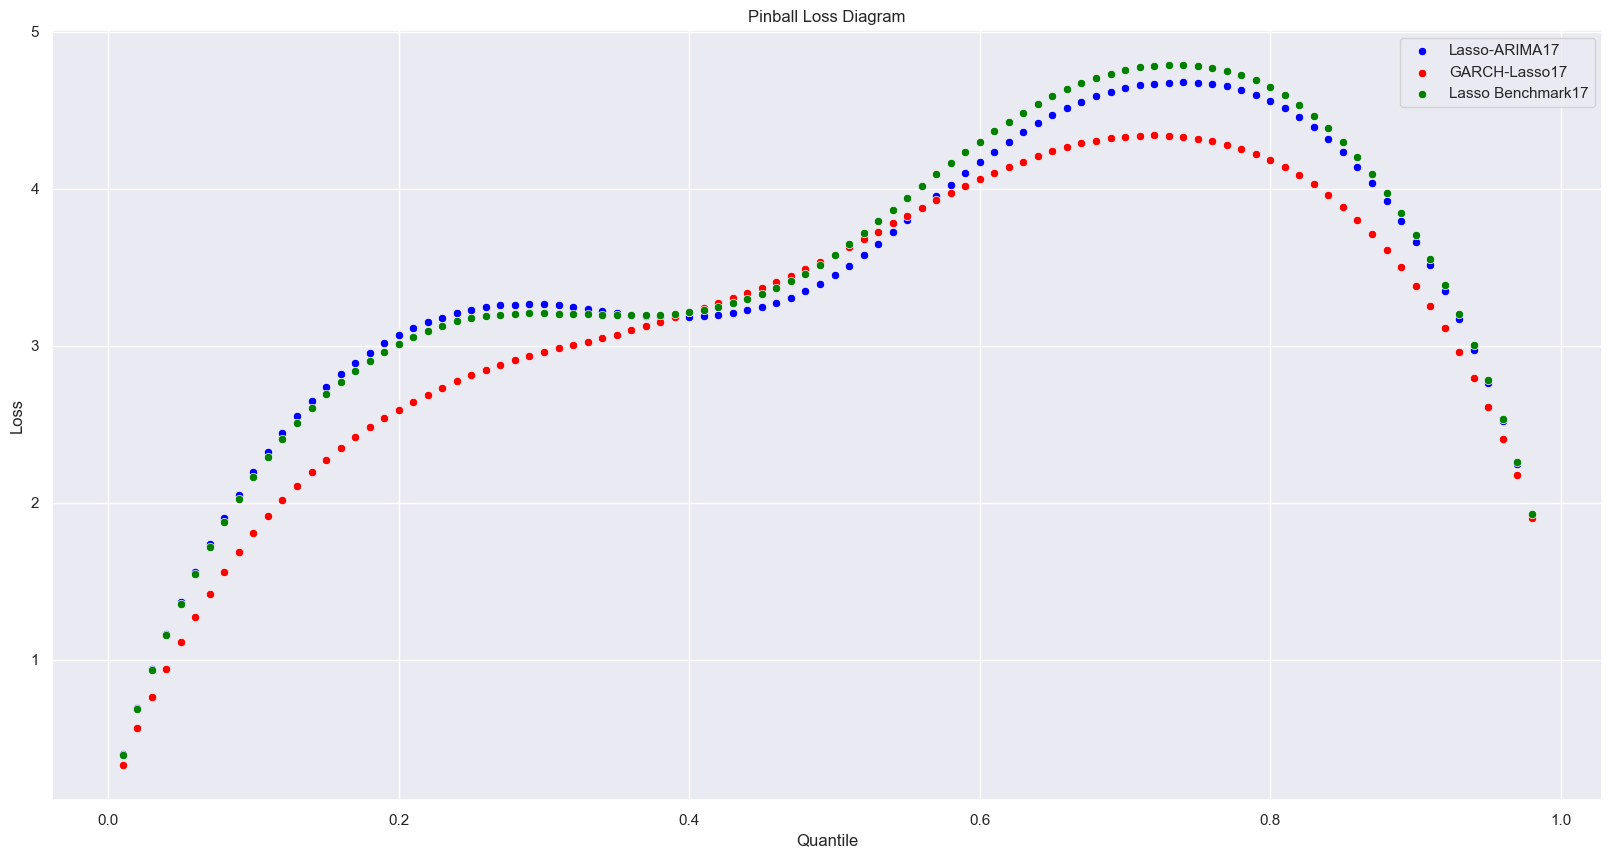

In [354]:
%load_ext autoreload

%autoreload 2


pinball_loss_norm(lasso_arima_results[h],
                  obs='Actual Value',
                  mu='Predicted Value',
                  std='STD',
                  l='Lasso-ARIMA' + str(h),
                  c='blue')
pinball_loss_norm(garch_lasso_results[h],
                  obs='Actual Value',
                  mu='Predicted Value',
                  std='STD',
                  l='GARCH-Lasso' + str(h),
                  c='red')
pinball_loss_norm(lasso_mean_results[h],
                  obs='Actual Value',
                  mu='Predicted Value',
                  std='STD',
                  l='Lasso Benchmark' + str(h),
                  c='green')

# Revising

In [406]:
f_price = glob.glob(path_price + "/*.csv")
dprice = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_price]

price_ts = pd.concat(dprice)
price_ts = price_ts[price_ts['AreaCode'] == '10YGB----------A']
price_ts = price_ts[['DateTime', 'Price']]
price_ts.sort_values(by='DateTime', ascending=True)
price_ts.reset_index(drop=True)
price_ts.set_index('DateTime', inplace=True)
price_ts = price_ts.resample('H').fillna('nearest')
price_ts


,Price
DateTime,
2014-12-18 23:00:00,39.91
2014-12-19 00:00:00,36.59
2014-12-19 01:00:00,31.91
2014-12-19 02:00:00,22.53
2014-12-19 03:00:00,20.96
...,...
2020-12-31 18:00:00,71.30
2020-12-31 19:00:00,61.04
2020-12-31 20:00:00,60.39


In [407]:
f_windoff = glob.glob(path_windsolar + "/*.csv")
dwindoff = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windoff]

windoff_ts = pd.concat(dwindoff)
windoff_ts = windoff_ts[windoff_ts['AreaCode'] == '10YGB----------A']
windoff_ts = windoff_ts[windoff_ts['ProductionType'] == 'Wind Offshore']
windoff_ts = windoff_ts[['DateTime', 'AggregatedGenerationForecast']]
windoff_ts.rename(columns={"AggregatedGenerationForecast":"Wind OffGeneration"}, inplace=True)
windoff_ts.sort_values(by='DateTime', ascending=True)
windoff_ts.reset_index(drop=True)
windoff_ts.drop_duplicates(subset=['DateTime'], inplace=True)
windoff_ts.set_index('DateTime', inplace=True)


In [408]:
test = pd.merge(price_ts, windoff_ts, right_index=True, left_index=True)
test = test.asfreq('H')
test.index

In [409]:
test = test.asfreq('H')

In [410]:
test.index

DatetimeIndex(['2014-12-30 00:00:00', '2014-12-30 01:00:00',
               '2014-12-30 02:00:00', '2014-12-30 03:00:00',
               '2014-12-30 04:00:00', '2014-12-30 05:00:00',
               '2014-12-30 06:00:00', '2014-12-30 07:00:00',
               '2014-12-30 08:00:00', '2014-12-30 09:00:00',
               ...
               '2020-12-31 13:00:00', '2020-12-31 14:00:00',
               '2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=52655, freq='H')

In [411]:
f_windon = glob.glob(path_windsolar + "/*.csv")
dwindon = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windon]

windon_ts = pd.concat(dwindon)
windon_ts = windon_ts[windon_ts['AreaCode'] == '10YGB----------A']
windon_ts = windon_ts[windon_ts['ProductionType'] == 'Wind Onshore']
windon_ts = windon_ts[['DateTime', 'AggregatedGenerationForecast']]
windon_ts.rename(columns={"AggregatedGenerationForecast":"Wind OnGeneration"}, inplace=True)
windon_ts.sort_values(by='DateTime', ascending=True)
windon_ts.reset_index(drop=True)
windon_ts.drop_duplicates(subset=['DateTime'], inplace=True)
windon_ts.set_index('DateTime', inplace=True)

In [412]:
test = pd.merge(test, windon_ts, right_index=True, left_index=True)

In [413]:
f_solar = glob.glob(path_windsolar + "/*.csv")
dsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_solar]

solar_ts = pd.concat(dsolar)
solar_ts = solar_ts[solar_ts['AreaCode'] == '10YGB----------A']
solar_ts = solar_ts[solar_ts['ProductionType'] == 'Solar']
solar_ts = solar_ts[['DateTime', 'AggregatedGenerationForecast']]
solar_ts.rename(columns={"AggregatedGenerationForecast":"Solar Generation"}, inplace=True)
solar_ts.sort_values(by='DateTime', ascending=True)
solar_ts.reset_index(drop=True)
solar_ts.drop_duplicates(subset=['DateTime'], inplace=True)
solar_ts.set_index('DateTime', inplace=True)

In [414]:
test = pd.merge(test, solar_ts, right_index=True, left_index=True)

In [415]:
test

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation
DateTime,,,,
2014-12-30 00:00:00,42.97,996.58,2363.80,0.0
2014-12-30 01:00:00,40.13,1059.20,2413.88,0.0
2014-12-30 02:00:00,36.90,1123.27,2450.75,0.0
2014-12-30 03:00:00,34.98,1177.54,2500.78,0.0
2014-12-30 04:00:00,33.63,1188.21,2536.07,0.0
...,...,...,...,...
2020-12-31 18:00:00,71.30,2644.97,3028.41,0.0
2020-12-31 19:00:00,61.04,2707.55,3046.72,0.0
2020-12-31 20:00:00,60.39,2695.01,3053.60,0.0


In [416]:
ddemand = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\demandto2020.csv',
                       parse_dates=['time'])
demand_ts = ddemand[['time', 'ND']]
demand_ts.rename(columns={"time":"DateTime",
                          "ND":"Demand"}, inplace=True)

demand_ts.sort_values(by='DateTime', ascending=True)
demand_ts.reset_index(drop=True, inplace=True)
demand_ts.set_index('DateTime', inplace=True)
demand_ts = demand_ts.resample('H').sum()
df_model = pd.merge(test, demand_ts, right_index=True, left_index=True)

In [417]:
test = pd.merge(test, demand_ts, right_index=True, left_index=True)

In [418]:
test

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand
DateTime,,,,,
2014-12-30 00:00:00,42.97,996.58,2363.80,0.0,63271
2014-12-30 01:00:00,40.13,1059.20,2413.88,0.0,60951
2014-12-30 02:00:00,36.90,1123.27,2450.75,0.0,59496
2014-12-30 03:00:00,34.98,1177.54,2500.78,0.0,57390
2014-12-30 04:00:00,33.63,1188.21,2536.07,0.0,55862
...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2644.97,3028.41,0.0,85279
2020-12-31 19:00:00,61.04,2707.55,3046.72,0.0,83146
2020-12-31 20:00:00,60.39,2695.01,3053.60,0.0,77395


<AxesSubplot:xlabel='DateTime', ylabel='Wind OffGeneration'>

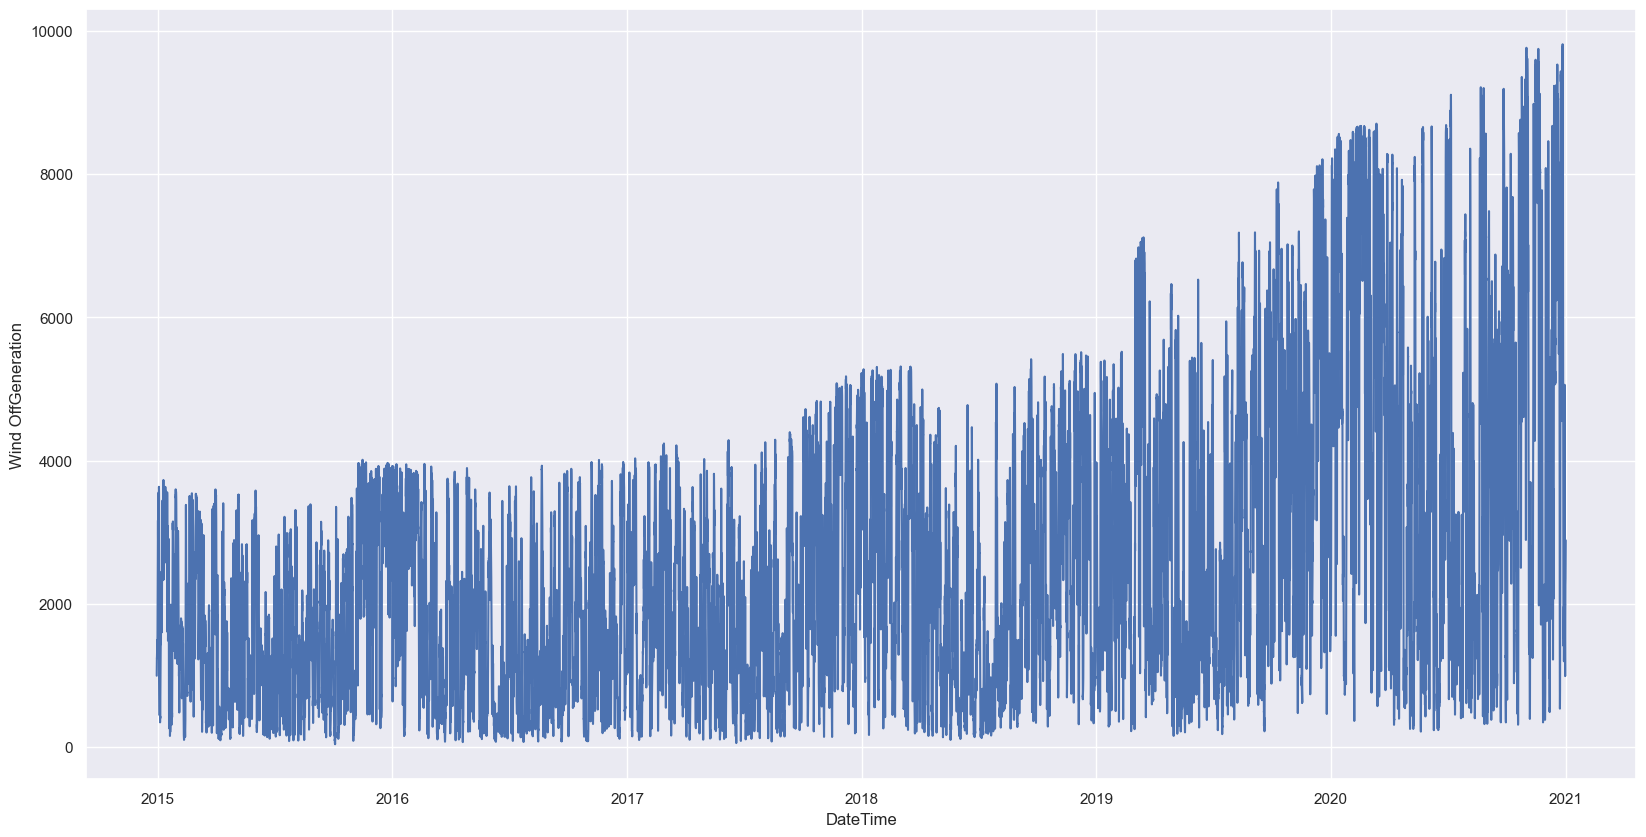

In [419]:
sns.lineplot(x=test.index, y=test['Wind OffGeneration'])

In [420]:
test = test.resample('H').fillna('nearest')

In [424]:
test

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand
DateTime,,,,,
2014-12-30 00:00:00,42.97,996.58,2363.80,0.0,63271
2014-12-30 01:00:00,40.13,1059.20,2413.88,0.0,60951
2014-12-30 02:00:00,36.90,1123.27,2450.75,0.0,59496
2014-12-30 03:00:00,34.98,1177.54,2500.78,0.0,57390
2014-12-30 04:00:00,33.63,1188.21,2536.07,0.0,55862
...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2644.97,3028.41,0.0,85279
2020-12-31 19:00:00,61.04,2707.55,3046.72,0.0,83146
2020-12-31 20:00:00,60.39,2695.01,3053.60,0.0,77395
